LSTM training code with:

No CODS_CO_STATION

Binary classification label (performance_issue)

Validation loss tracking

Best model checkpoint logic

Final loss plot

Epoch 1: Train Loss=0.1751, Val Loss=0.1690
Epoch 2: Train Loss=0.1695, Val Loss=0.1673
Epoch 3: Train Loss=0.1667, Val Loss=0.1651
Epoch 4: Train Loss=0.1650, Val Loss=0.1656
Epoch 5: Train Loss=0.1636, Val Loss=0.1631
Epoch 6: Train Loss=0.1623, Val Loss=0.1609
Epoch 7: Train Loss=0.1611, Val Loss=0.1608
Epoch 8: Train Loss=0.1599, Val Loss=0.1595
Epoch 9: Train Loss=0.1587, Val Loss=0.1590
Epoch 10: Train Loss=0.1576, Val Loss=0.1587
Epoch 11: Train Loss=0.1565, Val Loss=0.1589
Epoch 12: Train Loss=0.1557, Val Loss=0.1578
Epoch 13: Train Loss=0.1546, Val Loss=0.1576
Epoch 14: Train Loss=0.1537, Val Loss=0.1569
Epoch 15: Train Loss=0.1530, Val Loss=0.1563
Epoch 16: Train Loss=0.1519, Val Loss=0.1564
Epoch 17: Train Loss=0.1512, Val Loss=0.1566
Epoch 18: Train Loss=0.1505, Val Loss=0.1570
Epoch 19: Train Loss=0.1497, Val Loss=0.1570
Epoch 20: Train Loss=0.1489, Val Loss=0.1569
✅ Best model saved.


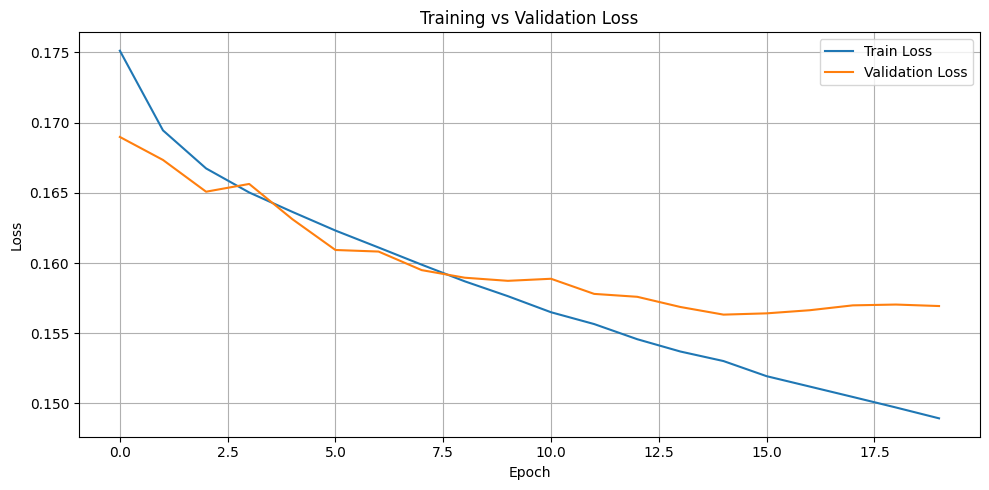

In [16]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv("./DATA/data5day.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])

# 2. Create label
df['performance_issue'] = (df['AVG_PROCESSING_TIME_MINUTES'] > 10).astype(int)

# 3. Encode CHUTE and ZIP_CODE
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

# 4. Sort chronologically
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# 5. Add engineered features
df['chute_load'] = df.groupby(['CHUTE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
df['zip_package_count'] = df.groupby(['ZIP_CODE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
df['hour_of_day'] = df['HOUR_TIME'].dt.hour
df['day_of_week'] = df['HOUR_TIME'].dt.dayofweek  # Monday = 0

# 6. Define features and targets
features = [
    'CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
'CHUTE_LOAD','ZIP_PACKAGE_COUNT','HOUR_OF_DAY','DAY_OF_WEEK'
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'performance_issue'

# 7. Normalize
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# 8. Create sequences for LSTM
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# 9. Create DataLoaders
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# 10. Define LSTM Hybrid Model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.sigmoid(self.fc_cls(out))

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()
criterion_cls = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 11. Train model
train_losses, val_losses = [], []
best_val_loss = float("inf")
best_model_state = None

for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

# 12. Save model
torch.save(best_model_state, "best_lstm_hybrid.pt")
print("✅ Best model saved.")

# 13. Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Add a Function: predict_at_time()

In [17]:
def predict_new_data(new_df, model, feature_scaler, target_scaler, seq_len=5):
    new_df = new_df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)
    new_df['HOUR_TIME'] = pd.to_datetime(new_df['HOUR_TIME'])

    # Encode
    new_df['CHUTE'] = new_df['CHUTE'].astype('category').cat.codes
    new_df['ZIP_CODE'] = new_df['ZIP_CODE'].astype('category').cat.codes

    # Scale input features
    new_df[features] = feature_scaler.transform(new_df[features])

    # Create sequences
    data = new_df[features].values
    X_new = [data[i:i+seq_len] for i in range(len(data) - seq_len)]
    X_new_tensor = torch.tensor(np.array(X_new), dtype=torch.float32)

    # Predict
    with torch.no_grad():
        y_pred_reg, y_pred_cls = model(X_new_tensor)
        predicted_time = target_scaler.inverse_transform(y_pred_reg.view(-1).reshape(-1, 1)).flatten()
        predicted_flag = (y_pred_cls.view(-1).numpy() > 0.5).astype(int)

    return pd.DataFrame({
        "Predicted_Processing_Time": predicted_time,
        "Predicted_Performance_Issue": predicted_flag
    })


In [18]:
def predict_at_time(df_raw, target_time, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])

    # Get rows before or at the specified time
    df = df_raw[df_raw['HOUR_TIME'] <= pd.to_datetime(target_time)]
    df = df.sort_values(by='HOUR_TIME').reset_index(drop=True)

    if len(df) < seq_len:
        print("❌ Not enough history before the given time.")
        return None

    seq_df = df.iloc[-seq_len:].copy()

    # Encode and scale
    seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
    seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes
    seq_df[features] = feature_scaler.transform(seq_df[features])

    x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

    with torch.no_grad():
        y_pred_reg, y_pred_cls = model(x_seq)
        predicted_time = target_scaler.inverse_transform(
            y_pred_reg.view(-1).reshape(-1, 1)
        ).flatten()[0]
        predicted_issue = int(y_pred_cls.view(-1).item() > 0.5)

    print(f"📅 Time: {target_time}")
    print(f"⏱️ Predicted Avg Processing Time: {predicted_time:.2f} minutes")
    print(f"🚨 Performance Issue: {'YES' if predicted_issue else 'NO'}")

    return predicted_time, predicted_issue


In [19]:
# Full prediction on a CSV
new_data = pd.read_csv("./DATA/data5day.csv")
results = predict_new_data(new_data, model, feature_scaler, target_scaler)
print(results.head())

# Single point in time
predict_at_time(new_data, "2025-03-21 22:00", model, feature_scaler, target_scaler)


   Predicted_Processing_Time  Predicted_Performance_Issue
0                   1.213847                            0
1                   1.568898                            0
2                   1.852117                            0
3                   3.904346                            0
4                   2.930244                            0
📅 Time: 2025-03-21 22:00
⏱️ Predicted Avg Processing Time: 3.71 minutes
🚨 Performance Issue: NO


C:\Users\mansourmoa\AppData\Local\Temp\ipykernel_30764\2373004233.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)


(np.float64(3.7068893745541565), 0)